# Challenge description:

Alert incident in transactions: Implement the concept of a simple monitoring with real time alert with notifications to teams.

The monitoring works by receiving information about a transaction and inferring whether it is a failed or denied, or reversed or aprroved transaction. We work mostly with SQL, PromQL, Ruby and Python, but you can use any programming language that you want.

Please use the data of [transactions1] and the data of [transactions2]. Consider that transactions with the flag denied are transactions denied by risk of the issuers. Consider that transactions with the flag reversed or failed are transactions with problems. Note: F1 represents the quantity of transactions per minute from all POS from our costumers. So with this data you can see the diferent status per minute and see if it is going well or not. When you see the padron, you can predict a alarm for the anomaly.

Your Monitoring alert system must have at least: 1 endpoint that receives transaction data and returns a recommendation to “alert” the anomalies found in transactions. A query to organize the data on the data and a graphic to see the data in real time. A model to determine anomalies and a system to report the anomalies automatically.

You are free to determine the methods to approve/deny the transactions, but a few ways to do it are:

1. rule-based - you define which cases get alerted based on predefined rules;
2. score-base - you create a method/model (you could use machine learning models here if you want) to determine the anomaly -- score of a transaction and make your decision based on it;
3. a combination of both;

**Monitoring alert Requirements**:

a. Alert transactions if failed transactions are above normal;

b. Alert transactions if reversed transactions are above normal;

c. Alert transactions if denied transactions are above normal;

# Importing Modules

In [33]:
import pickle

import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt

from datetime             import datetime, date
from matplotlib.dates     import DateFormatter
from IPython.display      import HTML, display, clear_output
from matplotlib.animation import FuncAnimation

In [34]:
# Adjust the width of the display container to 100%
display(HTML("<style>.container { width:100% !important; }</style>"))

# Set the font size for rendered HTML to 17px
display(HTML("<style>.rendered_html { font-size: 17px; }</style>"))

# Load datasets

In [35]:
# Read data from CSV files into Pandas DataFrames for transactions_1 and transactions_2
transactions_1_df = pd.read_csv('transactions_datasets/transactions_1.csv')
transactions_2_df = pd.read_csv('transactions_datasets/transactions_2.csv')

In [36]:
# Display information about the structure and data types of the transactions dataframes 
print(transactions_1_df.info(), '\n')
print(transactions_2_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4234 entries, 0 to 4233
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   time    4234 non-null   object
 1   status  4234 non-null   object
 2   f0_     4234 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 99.4+ KB
None 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3944 entries, 0 to 3943
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   time    3944 non-null   object
 1   status  3944 non-null   object
 2   count   3944 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 92.6+ KB
None


In [37]:
# Convert the 'time' column from string format to a proper time format
transactions_1_df['time'] = transactions_1_df.time.apply(lambda x: x.replace('h ', ':'))
transactions_1_df['time'] = pd.to_datetime(transactions_1_df['time'], format = '%H:%M').dt.time

transactions_2_df['time'] = transactions_2_df.time.apply(lambda x: x.replace('h ', ':'))
transactions_2_df['time'] = pd.to_datetime(transactions_2_df['time'], format = '%H:%M').dt.time

# Exploratory data analysis 

Let's examine the total status number for each transaction dataframe.

In [38]:
# Define a list of colors for different transaction statuses
colors_transactions = ['#a65628', '#ffff33', '#ff7f00', '#984ea3', '#4daf4a', '#e41a1c', '#377eb8']

In [39]:
# Display the count of values in the 'status' column
transactions_1_df['status'].value_counts()

approved            1299
denied              1140
reversed             725
refunded             423
backend_reversed     413
processing           181
failed                53
Name: status, dtype: int64

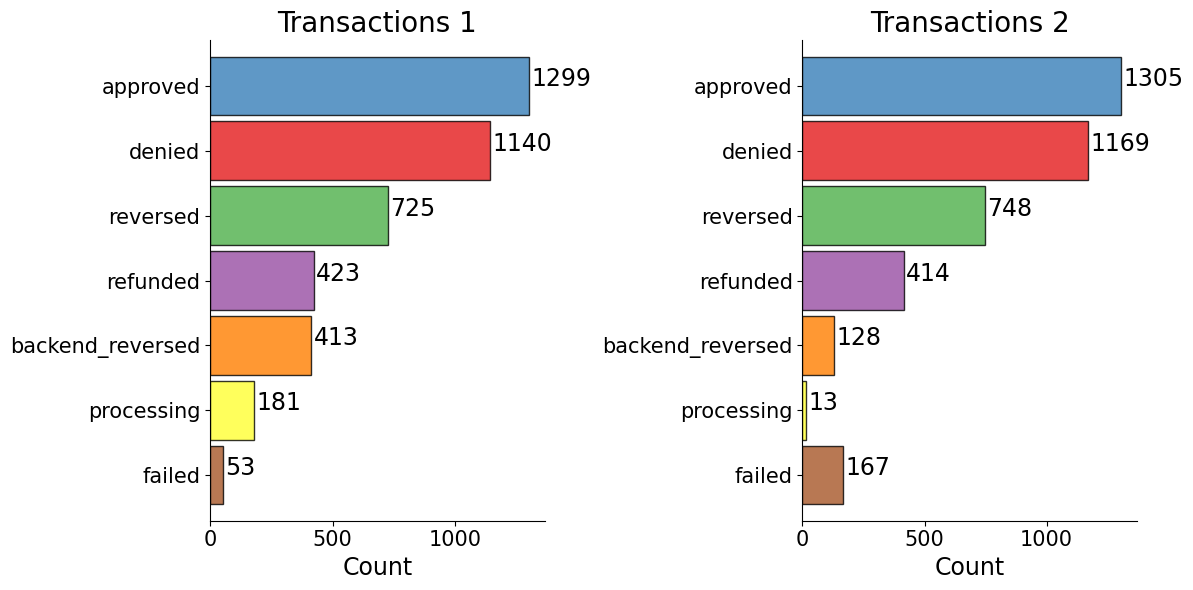

In [40]:
# Create subplots
f, ax = plt.subplots(figsize=(12, 6), ncols=2)

# Plot horizontal bar charts for Transactions 1
df1 = transactions_1_df['status'].value_counts(ascending=True)
df1.plot(kind='barh', ax=ax[0], width=0.90, stacked=True, mark_right=True, edgecolor='k', alpha=0.80, color=colors_transactions)

# Display count values next to the bars
for num, value in enumerate(df1.values):
    ax[0].text(x=value + 10, y=num, s=value, fontsize=17)

# Set labels, title, and adjust plot appearance for Transactions 1
ax[0].set_xlabel('Count', fontsize=17)
ax[0].tick_params(which='both', labelsize=15)
ax[0].set_title('Transactions 1', fontsize=20)
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)

# Plot horizontal bar charts for Transactions 2
df2 = transactions_2_df['status'].value_counts(ascending=True)
df2 = df2.reindex(list(df1.index))  # Make sure both subplots plot status in the same y-axis position
df2.plot(kind='barh', ax=ax[1], width=0.90, stacked=True, mark_right=True, edgecolor='k', alpha=0.80, color=colors_transactions)

# Display count values next to the bars
for num, value in enumerate(df2.values):
    ax[1].text(x=value + 10, y=num, s=value, fontsize=17)

# Set labels, title, and adjust plot appearance for Transactions 2
ax[1].set_xlabel('Count', fontsize=17)
ax[1].tick_params(which='both', labelsize=15)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].set_title('Transactions 2', fontsize=20)

# Adjust layout for better visualization
f.tight_layout()

# Show the plot
plt.show()

Except for backend_reversed, processing and failed statuses, the total number of the other status are quite similar between the two datasets

In [41]:
# Create a pivot table to get the count of each status per minute for Transactions 1
pivot_df1 = transactions_1_df.pivot_table(index='time', columns='status', values='f0_', aggfunc='max', fill_value=0)

# Reset the index and adjust column names
pivot_df1.reset_index(inplace=True)
pivot_df1.columns.name = None

# Rearrange columns to match the order in df1
pivot_df1 = pivot_df1[['time'] + list(df1.index[::-1])]

# Display the first 5 rows of the transformed DataFrame
pivot_df1.head(5)

,time,approved,denied,reversed,refunded,backend_reversed,processing,failed
0,00:00:00,9,6,0,1,0,0,0
1,00:01:00,13,8,0,0,0,0,0
2,00:02:00,11,7,0,1,0,0,0
3,00:03:00,12,3,0,0,0,0,0
4,00:04:00,11,0,0,0,0,0,0


Therefore, for every discrete minute, we obtain the count of transactions for each status. For example, during the minute 00:00:00 (i.e., 00:00:00 < t < 00:01:00), there were 9 approved, 6 denied, 0 reversed, 1 refunded, 0 backend_reversed, 0 processing, and 0 failed transactions.

In [42]:
# Doing the same process for transactions_2
# Create a pivot table to get the count of each status per minute for Transactions 2
pivot_df2 = transactions_2_df.pivot_table(index='time', columns='status', values='count', aggfunc='max', fill_value=0)

# Reset the index and adjust column names
pivot_df2.reset_index(inplace=True)
pivot_df2.columns.name = None

# Rearrange columns to match the order in df1
pivot_df2 = pivot_df2[['time'] + list(df1.index[::-1])]

# Display the first 5 rows of the transformed DataFrame
pivot_df2.head(5)

,time,approved,denied,reversed,refunded,backend_reversed,processing,failed
0,00:00:00,9,3,7,0,2,12,0
1,00:01:00,16,12,2,0,1,2,0
2,00:02:00,5,4,5,0,3,5,0
3,00:03:00,6,2,9,0,2,4,0
4,00:04:00,12,4,10,0,3,2,0


Let's analyze the number of transactions over time for each status type.

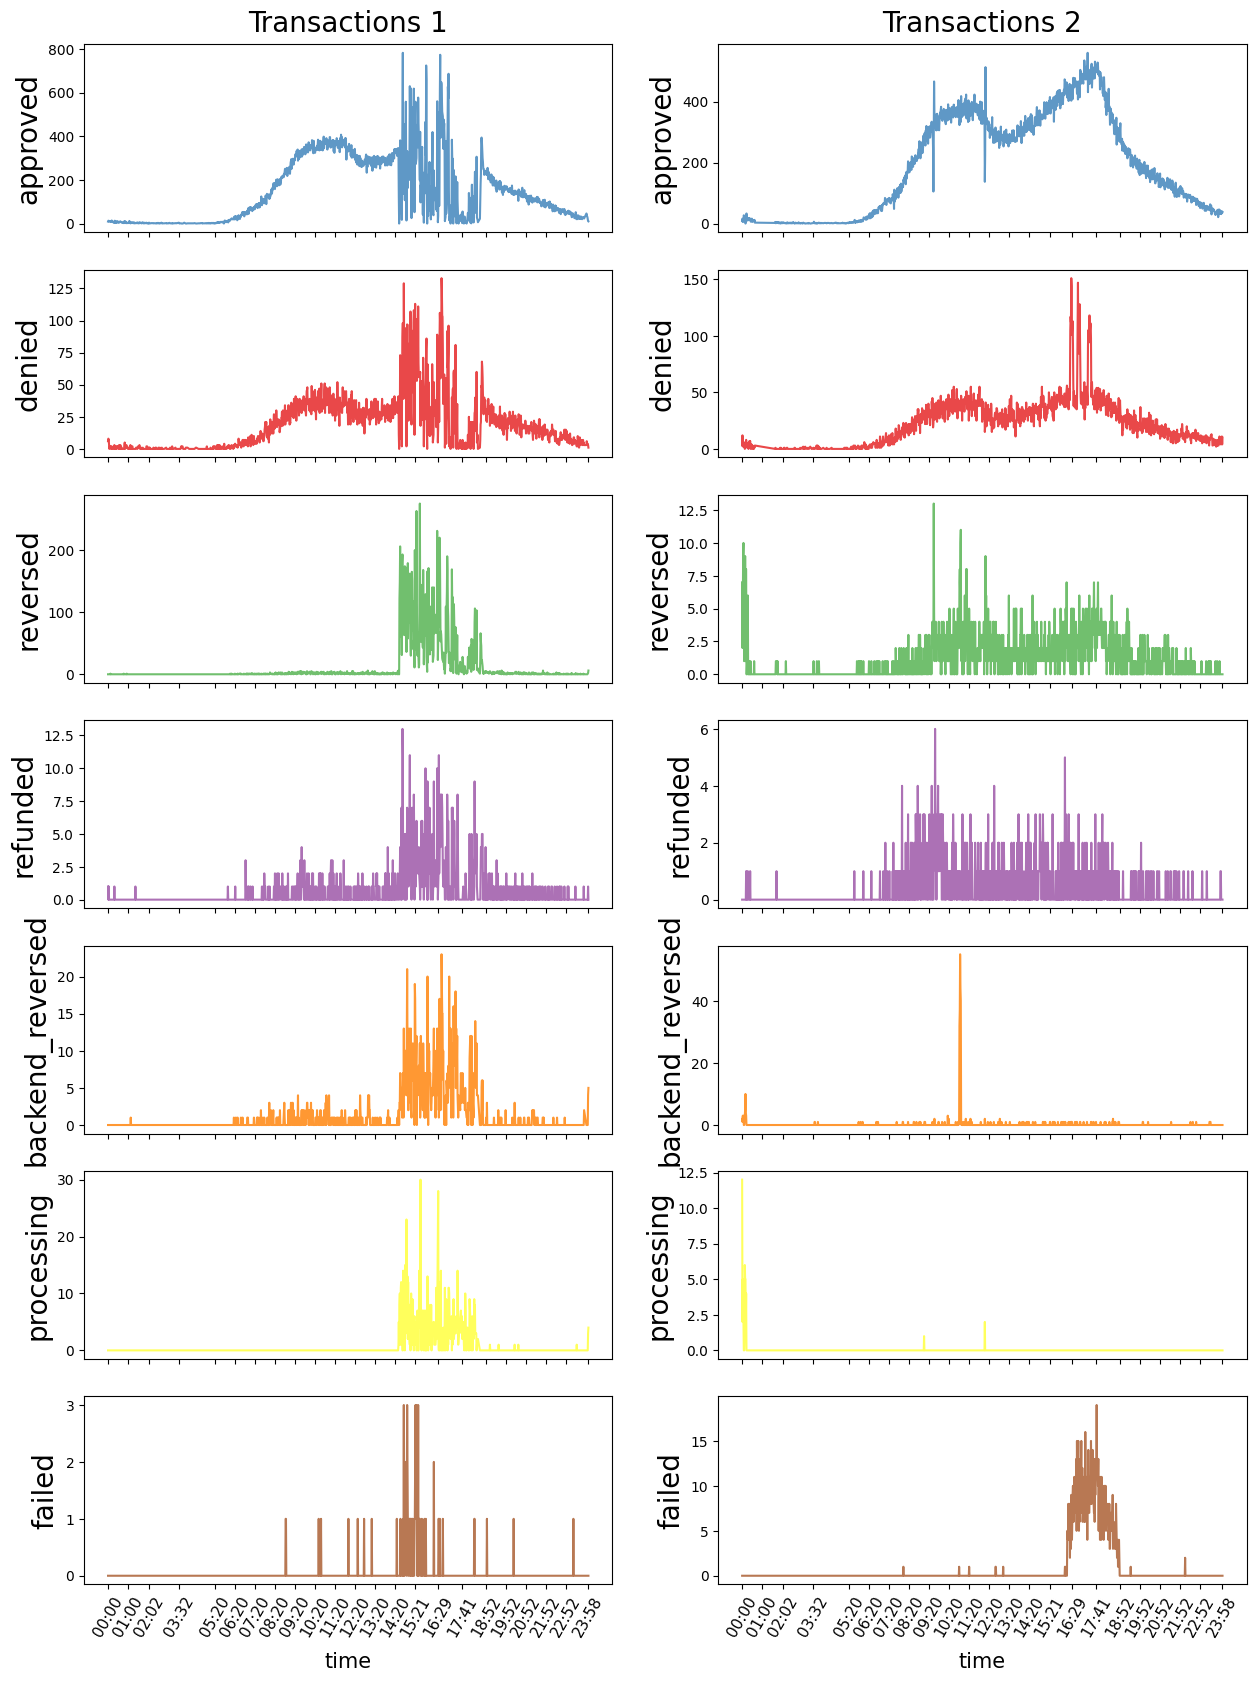

In [43]:
# Create subplots for each status to visualize the number of transactions over time for Transactions 1 and Transactions 2
f, ax = plt.subplots(figsize=(15, 20), nrows=7, ncols=2)

# Plot each status for Transactions 1 and Transactions 2
for num, column in enumerate(pivot_df1[pivot_df1.columns[1:]]):
    # Plot Transactions 1 data
    pivot_df1.plot(x='time', y=column, label=column, color=colors_transactions[::-1][num], alpha=0.8, ax=ax[num][0], legend=False)
    
    # Plot Transactions 2 data
    pivot_df2.plot(x='time', y=column, label=column, color=colors_transactions[::-1][num], alpha=0.8, ax=ax[num][1], legend=False)

    # Set y-axis labels for each subplot
    ax[num][0].set_ylabel(column, fontsize=20)
    ax[num][1].set_ylabel(column, fontsize=20)
    
    # Set x-axis tick parameters
    ax[num][0].tick_params(axis='x', labelsize=11, rotation=60)
    ax[num][1].tick_params(axis='x', labelsize=11, rotation=60)
    
    # Set x-axis ticks and labels for every hour
    ticks = pivot_df1['time'].values[::60]
    ax[num][0].set_xticks(ticks)
    ax[num][0].set_xticklabels([])
    
    ax[num][1].set_xticks(ticks)
    ax[num][1].set_xticklabels([])
    
    # Hide x-axis labels for the subplots
    ax[num][0].set_xlabel('')
    ax[num][1].set_xlabel('')

# Set titles for each subplot
ax[0][0].set_title('Transactions 1', fontsize=20, pad=9)
ax[0][1].set_title('Transactions 2', fontsize=20, pad=9)

# Set x-axis labels and adjust tick parameters for the bottom subplots
ax[-1][0].set_xlabel('time', fontsize=15, labelpad=9)
ax[-1][1].set_xlabel('time', fontsize=15, labelpad=9)

# Format x-axis labels to show hours and minutes
ax[num][0].set_xticklabels([i.strftime('%H:%M') for i in ticks]);
ax[num][1].set_xticklabels([i.strftime('%H:%M') for i in ticks]);

# Show the plot
plt.show()

**For transactions 1**:

For approved and denied statuses, I observe a increase from roughly 06:00 and a peak around roughly 10:00-11:00, followed by a decline at approximately 12:00. However, a peculiar behavior emerges after 14:00, persisting until almost 19:00.
    
The other status mostly display an increased behavior around that period of 14:00-19:00  

**For transactions 2**:

The behavior between 6:00 and 12:00 becomes more evident. Specifically for the 'approved' status, two outliers are observed in this interval. Subsequently, I observe an increase from 13:00 until 18:00, followed by a steady decrease until the end of the day. 
    
Regarding the 'denied' status, a similar pattern is observed, but with notable spikes occurring between 16:00 and 18:00 hours.

Both 'backend_reverse' and 'processing' exhibit substantial spikes in their respective time series. Conversely, 'failed' experiences an increase only around 16:00 and 19:00.

# Detecting anomalies

I will employ the z-score (https://en.wikipedia.org/wiki/Standard_score) approach to identify anomalous observations and spikes. The z-score quantifies the number of standard deviations a data point deviates from the mean. In this context, an instance with a high absolute z-score can be identified as an anomaly.

To refine this approach, I exclude all zero values from the distribution before applying the z-score. This adjustment is necessary as certain distributions, such as 'failed,' contain numerous zero values that can potentially skew the statistics (mean and standard deviation).

Without this exclusion, for example, every failed transaction in the transactions_1 dataset would be flagged as an anomaly, even if it occurs only once (a single failed transaction can be quite common in certain contexts). The trade-off is that now, even three failed transactions in a minute won't be flagged as anomalies. Nevertheless, considering that 3 is still relatively low, this should not pose a significant issue.

In [44]:
def detect_anomalies(array, threshold=3):
    """
    Detect anomalies in the given array based on z-scores.

    Parameters:
    - array (numpy.ndarray): Input array containing numerical data.
    - threshold (float, optional): Threshold for considering a data point as an anomaly. Default is 3.

    Returns:
    - anomaly_indices (numpy.ndarray): Indices of anomalous data points in the array.
    """
    # Calculate z-scores for the array
    z_scores = (array - np.mean(array)) / np.std(array)
    
    # Identify indices where absolute z-scores exceed the threshold
    anomaly_indices = np.where(np.abs(z_scores) > threshold)[0]

    return anomaly_indices

Since the challenge requirements are:

1. Alert transactions if failed transactions are above normal;
2. Alert transactions if reversed transactions are above normal;
3. Alert transactions if denied transactions are above normal;
    
I'm going to consider only these three status.

In [45]:
# Define the list of transaction statuses we are going to be using
statuses = ['failed', 'reversed', 'denied']

# Create a dictionary mapping each transaction status to its corresponding color
colors_dict = dict(zip(pivot_df1.columns[1:], colors_transactions[::-1]))

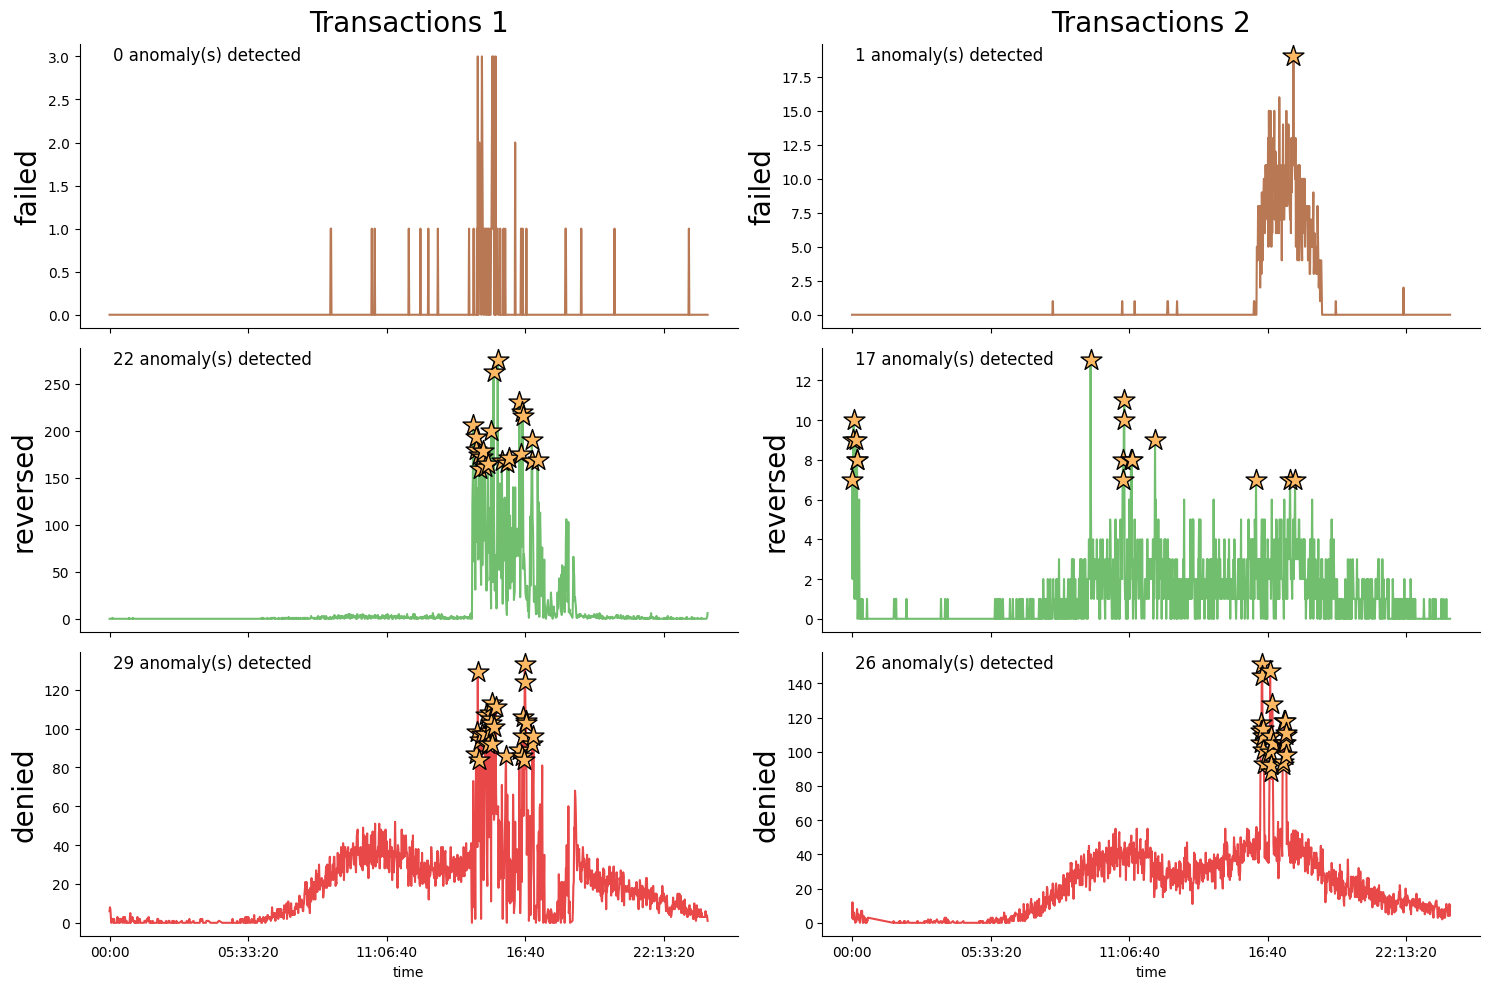

In [46]:
# Create subplots to visualize the number of transactions over time for selected statuses in Transactions 1 and Transactions 2
f, ax = plt.subplots(figsize=(15, 10), nrows=len(statuses), ncols=2, sharex=True)

# Loop through each transaction status
for num, column in enumerate(statuses):
    # Plot Transactions 1 data
    pivot_df1.plot(x='time', y=column, label=column, color=colors_dict[column], alpha=0.8, ax=ax[num][0], legend=False)
    
    # Detect anomalies in Transactions 1 data
    # But first, remove the zeros from the distribution
    df1_without_zeros = pivot_df1[pivot_df1[column] != 0]
    time1 = df1_without_zeros['time'].values
    anomaly_indices1 = detect_anomalies(df1_without_zeros[column].values)
    
    # Mark anomalies with a star marker in the plot
    if len(anomaly_indices1):
        ax[num][0].scatter(time1[anomaly_indices1], df1_without_zeros[column].values[anomaly_indices1], marker='*', zorder=10, s=250, color='#fdb863', edgecolor='k')
    
    # Plot Transactions 2 data
    pivot_df2.plot(x='time', y=column, label=column, color=colors_dict[column], alpha=0.8, ax=ax[num][1], legend=False)
    
    # Detect anomalies in Transactions 2 data
    df2_without_zeros = pivot_df2[pivot_df2[column] != 0]
    time2 = df2_without_zeros['time'].values
    anomaly_indices2 = detect_anomalies(df2_without_zeros[column].values)
    
    # Mark anomalies with a star marker in the plot
    if len(anomaly_indices2):
        ax[num][1].scatter(time2[anomaly_indices2], df2_without_zeros[column].values[anomaly_indices2], marker='*', zorder=10, s=250, color='#fdb863', edgecolor='k')
    
    # Display the number of detected anomalies for each subplot
    ax[num][0].text(0.05, 0.99, f'{len(anomaly_indices1)} anomaly(s) detected', va='top', fontsize=12, transform=ax[num][0].transAxes)
    ax[num][1].text(0.05, 0.99, f'{len(anomaly_indices2)} anomaly(s) detected', va='top', fontsize=12, transform=ax[num][1].transAxes)

    # Set y-axis labels for each subplot
    ax[num][0].set_ylabel(column, fontsize=20)
    ax[num][1].set_ylabel(column, fontsize=20)
    
    # Remove top and right spines for aesthetics
    ax[num][0].spines['top'].set_visible(False)
    ax[num][0].spines['right'].set_visible(False)
    
    ax[num][1].spines['top'].set_visible(False)
    ax[num][1].spines['right'].set_visible(False)

# Set titles for each subplot
ax[0][0].set_title('Transactions 1', fontsize=20, pad=9)
ax[0][1].set_title('Transactions 2', fontsize=20, pad=9)

# Adjust layout for better spacing
f.tight_layout()